# Autoencoders

## Import Dependencies and Packages

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K, metrics
from tensorflow.keras.datasets import mnist
from typing import Tuple

# Ensure TensorFlow is using the latest version
print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.18.0


## Setting Hyper-Parameters 
---
Tthis step is to set global variables and hyperparameters. They should all be familiar: the original dimensions are *28 × 28*, which is the standard size. We then flatten the images from the *MNIST* dataset, to get a vector of *784 (28 × 28)* dimensions. And we will also have a single intermediate layer of, say, *256* nodes.

In [33]:
# Define key parameters
batch_size = 100
original_dim = 784  # 28x28 images flattened
latent_dim = 2      # Dimensionality of the latent space
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

## Sampling helper function
---
Now we sample from the latent space and then feed this information through to the decoder. But think for a bit how *z_mean* and *z_log_var* are connected: they are both connected to *encoder_hidden - see encoder implementation, with a dense layer of two nodes, which are the defining characteristics of a normal distribution: *mean* and *variance*. The preceding sampling function is implemented bellow.


In [23]:
# Define the sampling function with type hints
def sampling(args: Tuple[tf.Tensor, tf.Tensor]) -> tf.Tensor:
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.0, stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

## Defining the Encoder
---
The short version is that we will simply declare each layer, mentioning the previous input as a *second group of arguments* after the regular arguments. For example, the layer *encoder_hidden* takes *encoder_input* as an input. At the end, when we compile the model and indicate where it
starts (encoder_input) and where it ends ([z_mean, z_log_var and z]), Keras will understand how the starting input and the final list output are linked together. Remember from the diagrams that *z* is our latent space, which in this case is a normal distribution defined by mean and variance. 

In [24]:
# Build the encoder model
# Input layer
encoder_input = layers.Input(shape=(original_dim,), name="encoder_input")

# Intermediate dense layer
encoder_hidden = layers.Dense(intermediate_dim, activation='relu', name="encoder_hidden")(encoder_input)

# Mean of the latent space
z_mean = layers.Dense(latent_dim, name="z_mean")(encoder_hidden)

# Log variance of the latent space
z_log_var = layers.Dense(latent_dim, name="z_log_var")(encoder_hidden)

# Sampling layer
z = layers.Lambda(sampling, name="z")([z_mean, z_log_var])

# Define the encoder model
encoder = models.Model(encoder_input, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_input       │ (None, 784)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_hidden      │ (None, 256)       │    200,960 │ encoder_input[0]… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 2)         │        514 │ encoder_hidden[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 2)         │        514 │ encoder_hidden[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Lambda)          │ (None, 2)         │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 201,988 (789.02 KB)

 Trainable params: 201,988 (789.02 KB)

 Non-trainable params: 0 (0.00 B)

## Defining the Decoder
---
The following is how the decoder is implemented, similar to the encoder logic.

In [25]:
# Build the decoder model
# Input for the decoder
decoder_input = layers.Input(shape=(latent_dim,), name="decoder_input")

# Intermediate dense layer
decoder_hidden = layers.Dense(intermediate_dim, activation='relu', name="decoder_hidden")(decoder_input)

# Output layer
decoder_output = layers.Dense(original_dim, activation='sigmoid', name="decoder_output")(decoder_hidden)

# Define the decoder model
decoder = models.Model(decoder_input, decoder_output, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ decoder_input (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_hidden (Dense)          │ (None, 256)            │           768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_output (Dense)          │ (None, 784)            │       201,488 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202,256 (790.06 KB)

 Trainable params: 202,256 (790.06 KB)

 Non-trainable params: 0 (0.00 B)

## Define the Variational Autoencoder (VAE)
---
A *VAE* consists of an encoder and a decoder.
- *Encoder*: Maps the input data (e.g., an image) to a distribution over a latent space, producing two outputs—*mean* (z_mean) and *log-variance* (z_log_var) of the latent variables.
- *Decoder*: Samples a point *z* from this latent distribution and attempts to reconstruct the input data from *z*.

***Loss Functions in VAE***
- *Reconstruction Loss*
    - *Purpose*: Measures how well the model can recreate the input data from the latent representation.
    - *Implementation*: Often uses binary cross-entropy or mean squared error between the input and reconstructed output.
    - *Intuition*: Encourages the model to preserve key features of the input so that the decoder can reconstruct it accurately.
- *KL Divergence Loss*
    - *Purpose*: Measures the difference between the learned latent distribution and a standard normal distribution (N(0, 1)).
    - *Implementation*: Calculates the Kullback-Leibler (KL) divergence, which is minimized when the learned latent distribution resembles a normal distribution.
    - *Intuition*: Encourages a smooth and continuous latent space by pushing the latent variables to follow a Gaussian distribution. This helps in generating new samples, as points sampled from this Gaussian distribution will yield plausible reconstructions.

In [30]:
# Define a custom VAE class
class VAE(models.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = metrics.Mean(name="kl_loss")
        
    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def train_step(self, data):
        if isinstance(data, tuple):
            x = data[0]
        else:
            x = data
        with tf.GradientTape() as tape:
            # Forward pass
            z_mean, z_log_var, z = self.encoder(x)
            x_decoded = self.decoder(z)
            # Compute reconstruction loss using Keras backend binary_crossentropy
            reconstruction_loss = K.binary_crossentropy(x, x_decoded)
            # reconstruction_loss has shape [batch_size, original_dim]
            reconstruction_loss = K.sum(reconstruction_loss, axis=1)  # Sum over features
            # Compute KL divergence loss
            kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
            kl_loss = K.sum(kl_loss, axis=1)
            kl_loss *= -0.5
            # Total loss
            total_loss = K.mean(reconstruction_loss + kl_loss)
        # Compute gradients
        grads = tape.gradient(total_loss, self.trainable_weights)
        # Update weights
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(K.mean(reconstruction_loss))
        self.kl_loss_tracker.update_state(K.mean(kl_loss))
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def test_step(self, data):
        if isinstance(data, tuple):
            x = data[0]
        else:
            x = data
        # Forward pass
        z_mean, z_log_var, z = self.encoder(x)
        x_decoded = self.decoder(z)
        # Compute reconstruction loss using Keras backend binary_crossentropy
        reconstruction_loss = K.binary_crossentropy(x, x_decoded)
        # reconstruction_loss has shape [batch_size, original_dim]
        reconstruction_loss = K.sum(reconstruction_loss, axis=1)  # Sum over features
        # Compute KL divergence loss
        kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        kl_loss = K.sum(kl_loss, axis=1)
        kl_loss *= -0.5
        # Total loss
        total_loss = K.mean(reconstruction_loss + kl_loss)
        # Update metrics
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(K.mean(reconstruction_loss))
        self.kl_loss_tracker.update_state(K.mean(kl_loss))
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        return self.decoder(z)

"""
def vae_loss(x, x_decoded_mean, z_log_var, z_mean,
    original_dim=original_dim):
    xent_loss = original_dim * objectives.binary_crossentropy(
        x, x_decoded_mean)
    kl_loss = - 0.5 * K.sum(
    1 + z_log_var - K.square(z_mean) - K.exp(z_log_var),
    axis=-1)
    return xent_loss + kl_loss
"""

''

## Initiate the VAE
---
We can now combine the encoder and the decoder into a single *VAE* model.

In [27]:
# Instantiate the VAE
vae = VAE(encoder, decoder)
vae.compile(optimizer='rmsprop')
vae.summary()

Model: "vae_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder (Functional)            │ [(None, 2), (None, 2), │       201,988 │
│                                 │ (None, 2)]             │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 784)            │       202,256 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 404,244 (1.54 MB)

 Trainable params: 404,244 (1.54 MB)

 Non-trainable params: 0 (0.00 B)

## Define the Dataset - MNIST
---
We train the model by using the standard procedure of train-test split and input normalization.

In [28]:
# Load and preprocess the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the data to [0, 1] and flatten the images
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape((-1, original_dim))
x_test = x_test.reshape((-1, original_dim))

## Train the Variational Autoencoder

In [29]:
# Train the VAE
history = vae.fit(
    x_train,
    epochs=epochs,
    batch_size=batch_size,
    shuffle=True,
    validation_data=(x_test, None)
)

Epoch 1/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 13.0833 - loss: 220.9507 - reconstruction_loss: 207.8674 - val_loss: 173.6390 - val_reconstruction_loss: 169.0698 - val_kl_loss: 4.5691
Epoch 2/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 4.6512 - loss: 173.1556 - reconstruction_loss: 168.5044 - val_loss: 168.3127 - val_reconstruction_loss: 163.4304 - val_kl_loss: 4.8823
Epoch 3/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 4.9138 - loss: 168.1078 - reconstruction_loss: 163.1941 - val_loss: 165.1316 - val_reconstruction_loss: 160.1353 - val_kl_loss: 4.9963
Epoch 4/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - kl_loss: 5.0674 - loss: 164.8673 - reconstruction_loss: 159.7999 - val_loss: 163.7198 - val_reconstruction_loss: 158.7019 - val_kl_loss: 5.0179
Epoch 5/50
600/600 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - kl_loss: 5.1526 - loss: 162.8458 - reconstruction_loss: 157.6932 - val_loss: 161.6696 - val_reconstruction_loss: 156.3891 - val_kl_loss: 5.2804
Epoch 6/5

## Plot the Train and Validation Losses

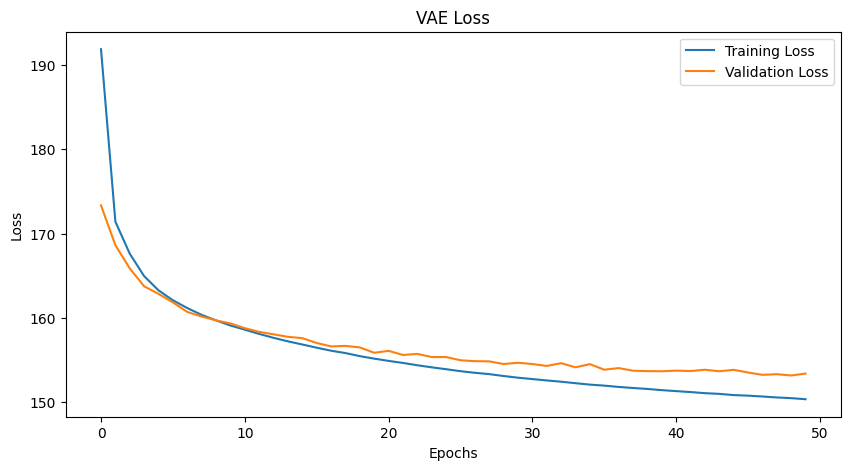

In [18]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('VAE Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Visualize the Latent Space

100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 808us/step


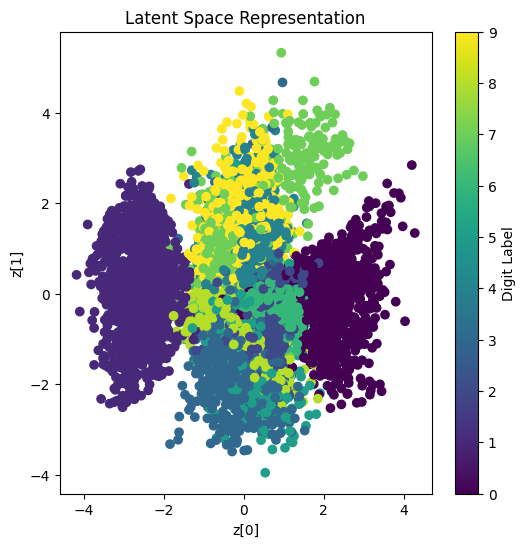

In [19]:
# Encode the test set
z_mean_test, z_log_var_test, z_test = encoder.predict(x_test, batch_size=batch_size)

plt.figure(figsize=(6, 6))
scatter = plt.scatter(z_test[:, 0], z_test[:, 1], c=y_test, cmap='viridis')
plt.colorbar(scatter, label='Digit Label')
plt.xlabel('z[0]')
plt.ylabel('z[1]')
plt.title('Latent Space Representation')
plt.show()

The figure shown above represents 2D projection of all the points from the test set into the latent space and their class. In this figure, we display the 2D latent space onto the graph. We then map out the classes of these generated examples and color them accordingly, as per the legend on the right. Here we can see that the classes tend to be neatly grouped together, which tells us that this is a good representation. 

## Generate a 2D Manifold of Digits

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━

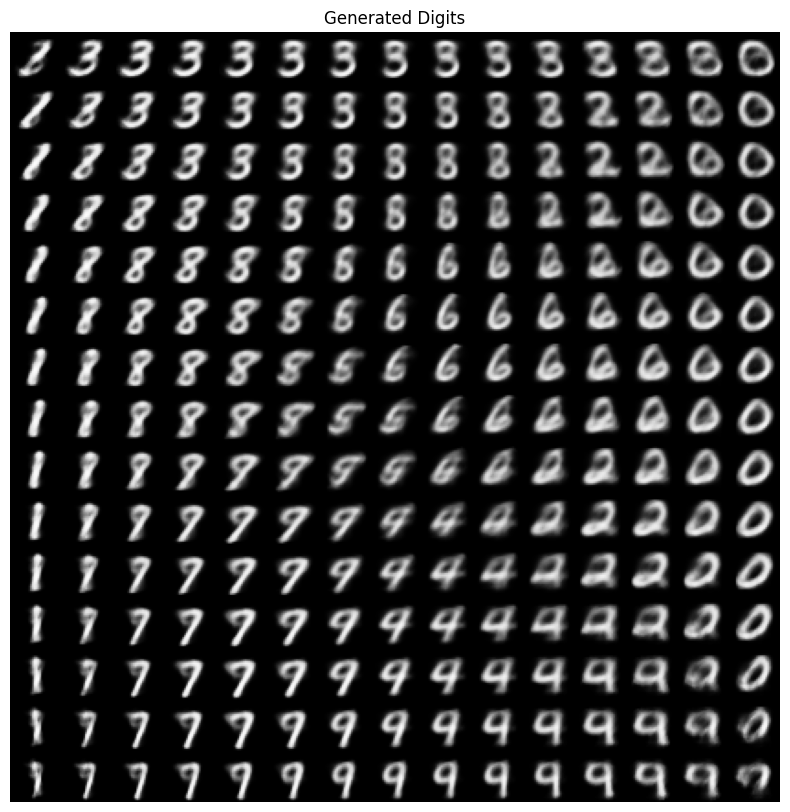

In [20]:
n = 15  # Grid size
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Define grid range based on the latent space
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.title('Generated Digits')
plt.axis('Off')
plt.show()